In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)


In [41]:
pipeline = "ood_imagenet_benchmark"
df = pd.read_csv(f"../results/{pipeline}/results.csv")
df = df.drop_duplicates(subset=["model", "method", "method_kwargs"], keep="last")
df.head()


,model,method,mos_inaturalist,mos_sun,mos_places365,textures,average,method_kwargs
14,resnet50d,vim,"{'fpr_at_0.95_tpr': 0.8685, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.793, 'tnr_at_0.95_tpr': ...","{'fpr_at_0.95_tpr': 0.7994, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.3173758865248227, 'tnr_a...","{'fpr_at_0.95_tpr': 0.6945689716312057, 'tnr_a...",{}
17,resnet50d,kl_matching,"{'fpr_at_0.95_tpr': 0.4848, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.7282, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.7489, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.6154255319148936, 'tnr_a...","{'fpr_at_0.95_tpr': 0.6443313829787234, 'tnr_a...",{}
23,swin_base_patch4_window7_224,msp,"{'fpr_at_0.95_tpr': 0.221, 'tnr_at_0.95_tpr': ...","{'fpr_at_0.95_tpr': 0.5518, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.5916, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.5225177304964539, 'tnr_a...","{'fpr_at_0.95_tpr': 0.47172943262411343, 'tnr_...",{}
24,swin_base_patch4_window7_224,energy,"{'fpr_at_0.95_tpr': 0.1498, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.4974, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.558, 'tnr_at_0.95_tpr': ...","{'fpr_at_0.95_tpr': 0.5274822695035462, 'tnr_a...","{'fpr_at_0.95_tpr': 0.43317056737588655, 'tnr_...",{}
25,swin_base_patch4_window7_224,max_logits,"{'fpr_at_0.95_tpr': 0.1416, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.4865, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.5387, 'tnr_at_0.95_tpr':...","{'fpr_at_0.95_tpr': 0.4836879432624113, 'tnr_a...","{'fpr_at_0.95_tpr': 0.4126219858156028, 'tnr_a...",{}


In [73]:
method_names = [
    "max_logits",
    "kl_matching",
    "igeood_logits",
    "gradnorm",
    "odin",
    "vim",
    "dice",
    "msp",
    "energy",
    "react",
    "gmm",
    "mahalanobis",
    "projection",
    "knn_euclides",
]
bmethods = {
    "max_logits": "MaxLogits",
    "kl_matching": "KLMatching",
    "odin": "ODIN",
    "igeood_logits": "IGEOOD",
    "dice": "DICE",
    "gradnorm": "GradNorm",
    "vim": "ViM",
    "msp": "MSP",
    "energy": "Energy",
    "react": "ReAct",
    "gmm": "GMM",
    "mahalanobis": "Mahalanobis",
    "projection": "Proj.",
    "knn_euclides": "KNN",
}
dataset_names = ["mos_inaturalist", "mos_sun", "mos_places365", "textures", "average"]
bdatasets = {
    "mos_inaturalist": "iNat",
    "mos_sun": "SUN",
    "mos_places365": "Places",
    "textures": "Textures",
    "average": "Average",
    "cifar10": "cifar10",
    "cifar100": "cifar100",
    "svhn": "svhn",
    "isun": "isun",
    "lsun_c": "lsun_c",
    "lsun_r": "lsun_r",
    "tiny_imagenet_c": "tiny_imagenet_c",
    "tiny_imagenet_r": "tiny_imagenet_r",
    "textures": "textures",
    "places365": "places365",
    "english_chars": "english_chars",
}
rkeys = ["tnr_at_0.95_tpr", "auroc"]
bkeys = {"tnr_at_0.95_tpr": "TNR", "auroc": "ROC"}


In [43]:
model_names = [
    "tv_resnet50",
    "tv_densenet121",
    "vit_base_patch16_224",
    "resnetv2_101x1_bitm",
    "mobilenetv3_large_100.ra_in1k",
    "mobilenetv3_small_100",
    "vit_base_patch16_384.orig_in21k_ft_in1k",
]
for model_name in model_names:
    sub = df.query("model == @model_name and method in @method_names")
    header = ["method"]
    for ds in dataset_names:
        header.append(bdatasets[ds])
        header.append("")
    subheader = [""]
    for ds in dataset_names:
        for rkey in rkeys:
            subheader.append(bkeys[rkey])
    lines = []
    for method_name in sorted(sub["method"].unique()):
        tmp = [bmethods[method_name]]
        for ds in dataset_names:
            data = sub.query("method == @method_name").iloc[0][ds]
            for rkey in rkeys:
                tmp.append(round(json.loads(data.replace("'", '"'))[rkey] * 100, 1))

        lines.append(tmp)

    table = [header, subheader] + lines
    res = pd.DataFrame(table[1:], columns=table[0])
    print(model_name)
    print(res.to_markdown(index=False))
    # print(res.to_csv(index=False))
    # print(res)


tv_resnet50
| method      | iNat   |      | SUN   |      | Places   |      | Textures   |      | Average   |      |
|:------------|:-------|:-----|:------|:-----|:---------|:-----|:-----------|:-----|:----------|:-----|
|             | TNR    | ROC  | TNR   | ROC  | TNR      | ROC  | TNR        | ROC  | TNR       | ROC  |
| DICE        | 72.3   | 94.3 | 62.6  | 90.7 | 51.0     | 87.4 | 67.6       | 90.6 | 63.4      | 90.7 |
| Energy      | 46.3   | 90.6 | 41.2  | 86.6 | 34.0     | 84.0 | 47.6       | 86.7 | 42.3      | 87.0 |
| GMM         | 2.1    | 46.3 | 1.0   | 38.6 | 0.9      | 38.6 | 34.5       | 81.7 | 9.6       | 51.3 |
| GradNorm    | 73.2   | 93.9 | 62.6  | 90.1 | 51.1     | 86.1 | 67.2       | 90.6 | 63.5      | 90.2 |
| IGEOOD      | 42.2   | 90.1 | 34.7  | 85.0 | 29.8     | 82.8 | 43.5       | 85.7 | 37.6      | 85.9 |
| KLMatching  | 52.8   | 89.7 | 25.7  | 80.4 | 23.7     | 78.9 | 34.2       | 82.5 | 34.1      | 82.9 |
| Mahalanobis | 2.8    | 59.9 | 2.9   | 50.2 | 2.3  

In [44]:
# rebuttal
model_names = [
    "tv_resnet50",
    "tv_densenet121",
    "vit_base_patch16_224",
    "vit_base_patch16_384.orig_in21k_ft_in1k"
]
pipeline = "ood_imagenet_benchmark"
df = pd.read_csv(f"../results/{pipeline}/results.csv")
df = df.drop_duplicates(subset=["model", "method", "method_kwargs"], keep="last")
df = df.query("method == 'mahalanobis' and model in @model_names")
for model_name in model_names:
    sub = df.query("model == @model_name")
    header = ["method"]
    for ds in dataset_names:
        header.append(bdatasets[ds])
        header.append("")
    subheader = [""]
    for ds in dataset_names:
        for rkey in rkeys:
            subheader.append(bkeys[rkey])
    lines = []
    for method_kw in sorted(sub["method_kwargs"].unique()):
        tmp = [method_kw]
        for ds in dataset_names:
            data = sub.query("method_kwargs == @method_kw").iloc[0][ds]
            for rkey in rkeys:
                tmp.append(round(json.loads(data.replace("'", '"'))[rkey] * 100, 1))

        lines.append(tmp)

    table = [header, subheader] + lines
    res = pd.DataFrame(table[1:], columns=table[0])
    print(model_name)
    print(res.to_markdown(index=False))
    # print(res.to_csv(index=False))
    # print(res)

tv_resnet50
| method                                                 | iNat   |      | SUN   |      | Places   |      | Textures   |      | Average   |      |
|:-------------------------------------------------------|:-------|:-----|:------|:-----|:---------|:-----|:-----------|:-----|:----------|:-----|
|                                                        | TNR    | ROC  | TNR   | ROC  | TNR      | ROC  | TNR        | ROC  | TNR       | ROC  |
| {'all_blocks': 1, 'aggregation_method_name': 'if'}     | 2.1    | 41.7 | 2.4   | 42.9 | 2.1      | 43.4 | 68.1       | 89.3 | 18.7      | 54.3 |
| {'all_blocks': 1, 'aggregation_method_name': 'max'}    | 2.5    | 57.8 | 3.7   | 50.2 | 2.4      | 45.3 | 53.9       | 88.5 | 15.6      | 60.5 |
| {'all_blocks': 1, 'aggregation_method_name': 'mean'}   | 2.8    | 60.0 | 2.8   | 50.2 | 2.4      | 46.5 | 72.2       | 93.8 | 20.1      | 62.6 |
| {'all_blocks': 1, 'aggregation_method_name': 'median'} | 2.8    | 51.3 | 2.7   | 48.9 | 2.7      | 44.7 

In [76]:
model_names = [
  "vit_base_patch16_224_in21k_ft_cifar100"
]
pipeline = "ood_cifar100_benchmark"
dataset_names = ["cifar10",
            "svhn",
            "isun",
            "lsun_c",
            "lsun_r",
            "tiny_imagenet_c",
            "tiny_imagenet_r",
            "textures",
            "places365",
            "english_chars",]
df = pd.read_csv(f"../results/{pipeline}/results.csv")
df = df.drop_duplicates(subset=["model", "method", "method_kwargs"], keep="last")
df = df.query("method == 'mahalanobis' and model in @model_names")
for model_name in model_names:
    sub = df.query("model == @model_name")
    header = ["method"]
    for ds in dataset_names:
        header.append(bdatasets[ds])
        header.append("")
    subheader = [""]
    for ds in dataset_names:
        for rkey in rkeys:
            subheader.append(bkeys[rkey])
    lines = []
    for method_kw in sorted(sub["method_kwargs"].unique()):
        tmp = [method_kw]
        for ds in dataset_names:
            data = sub.query("method_kwargs == @method_kw").iloc[0][ds]
            for rkey in rkeys:
                tmp.append(round(json.loads(data.replace("'", '"'))[rkey] * 100, 1))

        lines.append(tmp)

    table = [header, subheader] + lines
    res = pd.DataFrame(table[1:], columns=table[0])
    print(model_name)
    print(res.to_markdown(index=False))
    # print(res.to_csv(index=False))
    # print(res)

vit_base_patch16_224_in21k_ft_cifar100
| method                                                                                                                                                                                                                                                                   | cifar10   |      | svhn   |      | isun   |      | lsun_c   |      | lsun_r   |      | tiny_imagenet_c   |      | tiny_imagenet_r   |      | textures   |       | places365   |       | english_chars   |      |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------|:-----|:-------|:-----|:-------|:-----|:---------|:-----|:---------|:-----|:------------------|:-----|:------------------|:-----|:-----------|:------|:------------|:------|:----------------|:-----|
|    

----
32     3
33     5
34     8
35     7
36     0
37    10
38     9
39    12
40     4
41     6
42    11
43     2
44     1
Name: layer_idx, dtype: object
    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32           0.9862           0.0138          0.51805  0.404761  0.445483  0.562351 -35.963661  0.897759         3
33           0.9869           0.0131          0.51845  0.403470  0.449818  0.557216 -35.783306  0.912576         5
34           0.9624           0.0376          0.50615  0.512016  0.527042  0.478041 -34.301231  0.902338         8
35           0.9850           0.0150          0.51730  0.429889  0.477980  0.528114 -35.400040  0.912180         7
36           0.9671           0.0329          0.50855  0.473081  0.495841  0.505698 -39.353714  0.915099         0
37           0.7197           0.2803          0.38485  0.766142  0.764641  0.352614 -34.479290  0.911773        10
38           0.9328           0.0672      

/var/folders/3r/jcn8px597cz46f_z_wb2jjwr0000gp/T/ipykernel_60350/805510333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line["layer_idx"] = d.get("layer_idx", None)


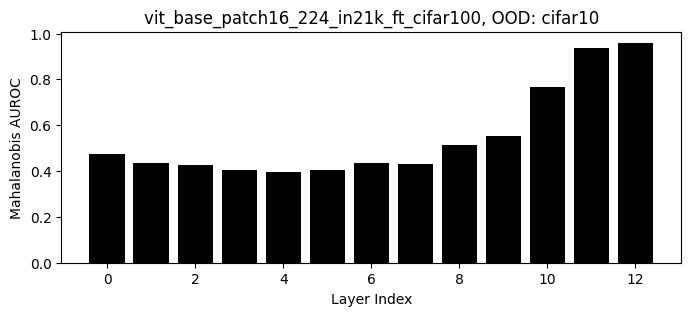

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32         0.104909         0.895091         0.089670  0.980899  0.965923  0.510351 -35.960331  0.897759         3
33         0.061770         0.938230         0.058504  0.986581  0.976558  0.509501 -35.783306  0.912576         5
34         0.022818         0.977182         0.030362  0.993495  0.987381  0.508353 -34.300140  0.902338         8
35         0.024201         0.975799         0.031361  0.992527  0.986434  0.508569 -35.383217  0.912180         7
36         0.939152         0.060848         0.692385  0.662295  0.455257  0.616236 -39.353714  0.915099         0
37         0.090197         0.909803         0.079041  0.979765  0.967539  0.510770 -34.479290  0.911773        10
38         0.038261         0.961739         0.041519  0.990243  0.981663  0.508828 -34.117607  0.917603         9
39         0.170521         0.829479         0.137073  0.959848  0.916233  0.513

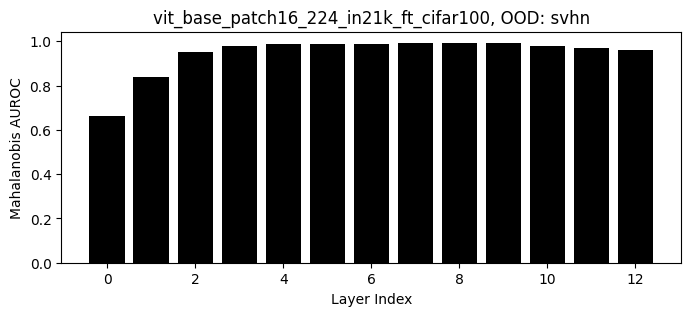

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32         0.042465         0.957535         0.046394  0.991243  0.992799  0.285756 -35.963661  0.897759         3
33         0.006162         0.993838         0.029326  0.998625  0.998786  0.285293 -35.783306  0.912576         5
34         0.060616         0.939384         0.054954  0.985432  0.989228  0.286608 -34.301231  0.902338         8
35         0.024314         0.975686         0.037781  0.993114  0.994681  0.285765 -35.392334  0.912180         7
36         0.160896         0.839104         0.102299  0.968450  0.974267  0.287980 -39.353714  0.915099         0
37         0.588011         0.411989         0.303725  0.912402  0.939194  0.297467 -34.479290  0.911773        10
38         0.160784         0.839216         0.102246  0.971030  0.979274  0.288413 -34.117607  0.917603         9
39         0.356751         0.643249         0.194663  0.936125  0.949601  0.292

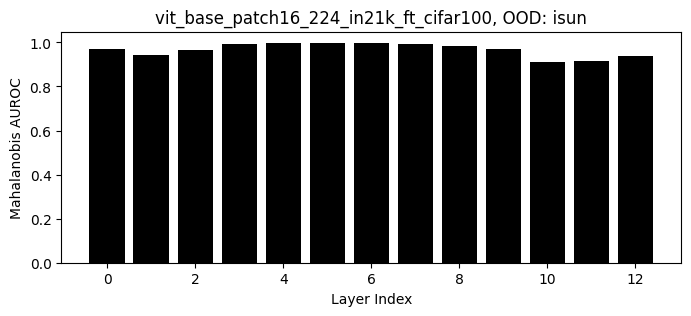

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32           0.0424           0.9576          0.04615  0.989883  0.991655  0.307748 -35.963661  0.897759         3
33           0.1053           0.8947          0.07765  0.981859  0.984545  0.308429 -35.783306  0.912576         5
34           0.2720           0.7280          0.16100  0.953664  0.959335  0.311610 -34.300140  0.902338         8
35           0.2425           0.7575          0.14625  0.961113  0.966567  0.310780 -35.383217  0.912180         7
36           0.0625           0.9375          0.05625  0.986638  0.987099  0.307603 -39.353714  0.915099         0
37           0.5152           0.4848          0.28260  0.899664  0.912186  0.320244 -34.479290  0.911773        10
38           0.3654           0.6346          0.20770  0.934975  0.942492  0.314213 -34.117607  0.917603         9
39           0.1929           0.8071          0.12145  0.963585  0.967330  0.310

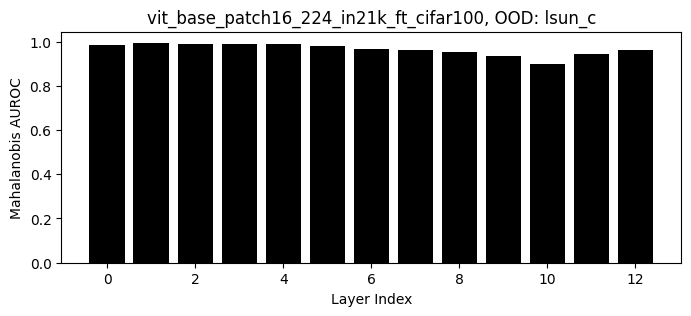

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32           0.0339           0.9661          0.04195  0.992849  0.993444  0.307258 -35.960331  0.897759         3
33           0.0020           0.9980          0.02590  0.999305  0.999315  0.306865 -35.828785  0.912576         5
34           0.0539           0.9461          0.05190  0.986105  0.989147  0.308318 -34.301231  0.902338         8
35           0.0155           0.9845          0.03275  0.994100  0.995146  0.307359 -35.383217  0.912180         7
36           0.1494           0.8506          0.09970  0.970296  0.974416  0.309809 -39.353714  0.915099         0
37           0.5911           0.4089          0.32055  0.918011  0.941651  0.319355 -34.479290  0.911773        10
38           0.1485           0.8515          0.09925  0.972786  0.979647  0.310190 -34.117607  0.917603         9
39           0.3004           0.6996          0.17520  0.944357  0.951332  0.312

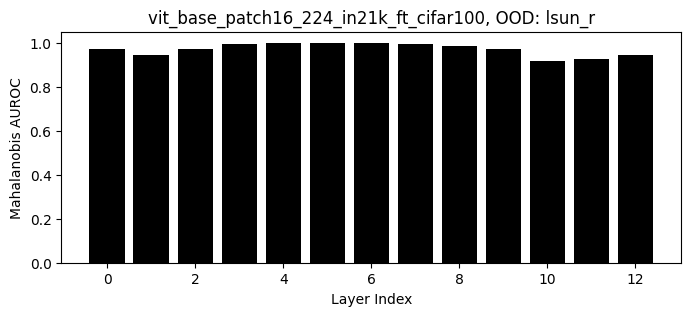

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32           0.0129           0.9871          0.03125  0.995462  0.996054  0.307157 -35.989059  0.897759         3
33           0.0101           0.9899          0.03000  0.997432  0.997540  0.306939 -35.815804  0.912576         5
34           0.1091           0.8909          0.07950  0.979265  0.982403  0.308756 -34.301231  0.902338         8
35           0.0560           0.9440          0.05300  0.988221  0.989633  0.307744 -35.383217  0.912180         7
36           0.0110           0.9890          0.03010  0.995862  0.996466  0.307179 -39.488914  0.915099         0
37           0.5084           0.4916          0.27920  0.914586  0.931643  0.318527 -34.479290  0.911773        10
38           0.2497           0.7503          0.14985  0.956630  0.963499  0.311556 -34.117607  0.917603         9
39           0.2346           0.7654          0.14230  0.953600  0.956532  0.311

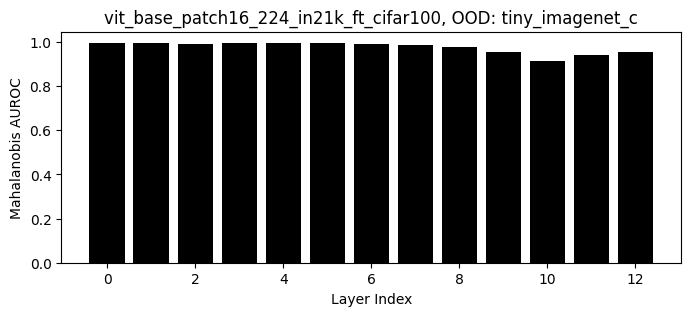

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32           0.0406           0.9594          0.04525  0.991592  0.992074  0.307298 -35.963661  0.897759         3
33           0.0063           0.9937          0.02810  0.998328  0.998322  0.306887 -35.815804  0.912576         5
34           0.0550           0.9450          0.05250  0.987110  0.989120  0.307976 -34.300140  0.902338         8
35           0.0300           0.9700          0.04000  0.992710  0.993431  0.307335 -35.383217  0.912180         7
36           0.1910           0.8090          0.12050  0.959693  0.960299  0.310319 -39.353714  0.915099         0
37           0.4445           0.5555          0.24725  0.930685  0.946344  0.316233 -34.479290  0.911773        10
38           0.1663           0.8337          0.10815  0.970337  0.975553  0.309966 -34.117607  0.917603         9
39           0.2748           0.7252          0.16240  0.945590  0.948415  0.312

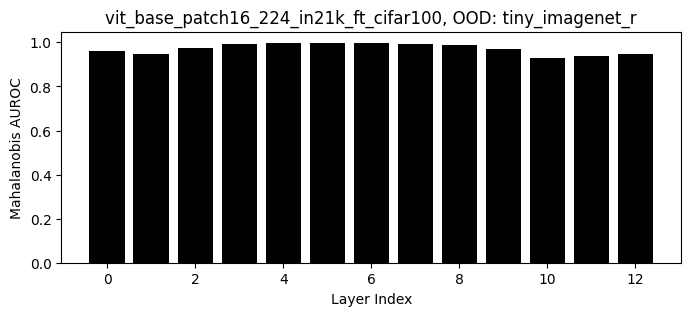

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32         0.000000         1.000000         0.014514  0.999991  0.999995  0.207010 -39.147362  0.897759         3
33         0.000177         0.999823         0.029604  0.999869  0.999925  0.207010 -36.170868  0.912576         5
34         0.001596         0.998404         0.027749  0.999251  0.999583  0.207024 -34.676884  0.902338         8
35         0.000532         0.999468         0.024361  0.999643  0.999801  0.207014 -36.171227  0.912180         7
36         0.000355         0.999645         0.015665  0.999914  0.999951  0.207010 -44.392296  0.915099         0
37         0.032979         0.967021         0.043542  0.990892  0.995369  0.207550 -34.507381  0.911773        10
38         0.006383         0.993617         0.034143  0.997453  0.998619  0.207100 -34.134392  0.917603         9
39         0.026418         0.973582         0.041496  0.992170  0.994646  0.207

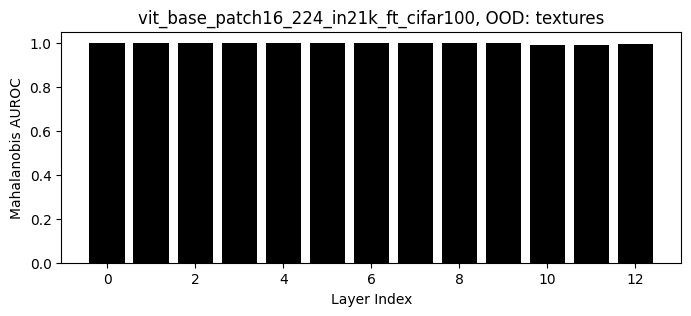

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32         0.000000         1.000000         0.007699  0.999994  0.999978  0.578941 -37.310188  0.897759         3
33         0.000356         0.999644         0.010925  0.998659  0.997239  0.579157 -35.861355  0.912576         5
34         0.050932         0.949068         0.050731  0.985383  0.973985  0.581570 -34.300140  0.902338         8
35         0.020548         0.979452         0.026882  0.989703  0.982241  0.580807 -35.383217  0.912180         7
36         0.000000         1.000000         0.006430  0.999983  0.999939  0.578941 -42.616043  0.915099         0
37         0.287726         0.712274         0.236602  0.951922  0.905643  0.587941 -34.479290  0.911773        10
38         0.110932         0.889068         0.097828  0.978447  0.959219  0.582767 -34.117607  0.917603         9
39         0.187808         0.812192         0.158172  0.966387  0.913738  0.584

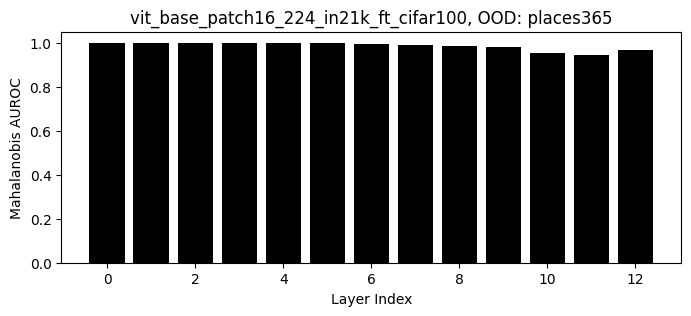

    fpr_at_0.95_tpr  tnr_at_0.95_tpr  detection_error     auroc   aupr_in  aupr_out        thr      time layer_idx
32         0.097339         0.902661         0.070545  0.983301  0.987880  0.259553 -35.963661  0.897759         3
33         0.031798         0.968202         0.042079  0.992327  0.994685  0.259037 -35.783306  0.912576         5
34         0.023751         0.976249         0.038181  0.993711  0.995587  0.258931 -34.313976  0.902338         8
35         0.018300         0.981700         0.036091  0.994741  0.996339  0.258872 -35.392334  0.912180         7
36         0.459442         0.540558         0.228184  0.856004  0.861155  0.276652 -39.353714  0.915099         0
37         0.064893         0.935107         0.056481  0.983627  0.989690  0.260127 -34.479290  0.911773        10
38         0.044257         0.955743         0.047444  0.989902  0.993026  0.259242 -34.123493  0.917603         9
39         0.100195         0.899805         0.071505  0.974580  0.977897  0.259

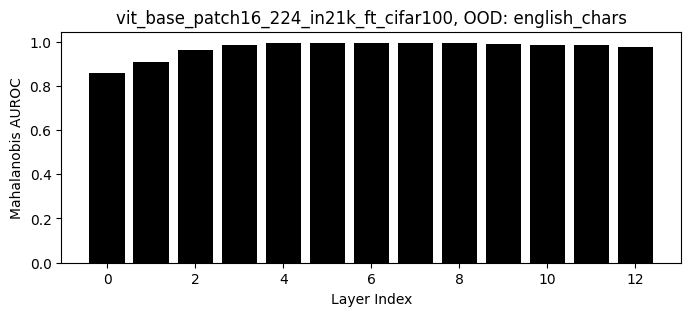

In [65]:
# layer_idx
model_names = [
  "vit_base_patch16_224_in21k_ft_cifar100"
]
pipeline = "ood_cifar100_benchmark"
dataset_names = ["cifar10",
            "svhn",
            "isun",
            "lsun_c",
            "lsun_r",
            "tiny_imagenet_c",
            "tiny_imagenet_r",
            "textures",
            "places365",
            "english_chars"]
df = pd.read_csv(f"../results/{pipeline}/results.csv")

df = df.drop_duplicates(subset=["model", "method", "method_kwargs"], keep="last")
df = df.query("method == 'mahalanobis' and model in @model_names")
df["layer_idx"] = None
json.loads(df.iloc[0]["method_kwargs"].replace("'", '"'))
for l in range(len(df)):
    line = df.iloc[l]
    d = json.loads(line["method_kwargs"].replace("'", '"'))
    d["layer_idx"] = d.get("layer_idx", None)
    # add layer_idx to df
    line["layer_idx"] = d.get("layer_idx", None)
    df.iloc[l] = line


    # df.loc[l, "layer_idx"] = d.get("layer_idx", None)
    # print(line)
print("----")
# filter layer_idx is nan
df = df.dropna(subset=["layer_idx"])
print(df["layer_idx"])
for dataset_name in dataset_names: 
  for model_name in model_names:
      sub = df.query("model == @model_name")
      res = sub[dataset_name].apply(lambda x: json.loads(x.replace("'", '"')))
      res = res.apply(pd.Series)
      res["layer_idx"] = sub["layer_idx"]
      print(res)

      fig = plt.figure(figsize=(8,3))
      x = res["layer_idx"]
      y = res["auroc"]
      plt.bar(x, y, color="black")
      plt.xlabel("Layer Index")
      plt.ylabel("Mahalanobis AUROC")
      plt.title(f"{model_name}, OOD: {dataset_name}")
      plt.show()
